In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

In [ ]:
# importa algunas funciones y los datos normalizados
from utils.py import *

## Definimos las funciones



In [ ]:
### Gráficas umbral binarización ###
#----------------------------------#
def thresh_plot(series, thresh):
    '''
    Dibuja una gráfica de <series> coloreando las partes por encima y por debajo
    del umbral <thresh>
    '''
    x = np.array(series.index)
    y = np.array(series)
    cmap = ListedColormap(['b','g','r'])
    norm = BoundaryNorm([-1,thresh,thresh,1], cmap.N)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(series)

    plt.figure()
    plt.gca().add_collection(lc)
    plt.plot([x.min(), x.max()],[thresh,thresh],"--",color="red")
    plt.xlim(x.min(), x.max())
    #plt.ylim(-1.1, 1.1)
    plt.show()

In [ ]:
### Binarización ###
#------------------#
def binarize(series, thresh):
    '''
    Devuelve la serie de datos binarizada de forma xt = 1 if xt <= <thresh>
    xt = 0 otherwise
    '''
    bin_series = series.copy(deep=True)
    bin_series[bin_series < thresh] = 0
    bin_series[bin_series != 0] = 1
    return bin_series

In [ ]:
### Enventanado ###
#-----------------#
def window(series, dt):
    '''
    Devuelve la serie de datos agrupada en ventanas de longitud <dt> tal que el
    valor en cada ventana es 1 si algún xt = 1 y 0 otherwise

    También devuelve el numero de spikes resultante en cada vetana y el número
    de spikes que continuan desde una ventana anterior (spikes cortadas)
    '''
    win_starts = np.arange(0, len(series), dt)
    win_series = np.zeros( len(win_starts) )
    # num_spikes = np.zeros( len(win_starts) ) #cambiadas para optimizar el tiempo de cálculo
    # num_cuts = np.zeros( len(win_starts) )

    for i in range(len(win_starts)):
        window = np.array(series[win_starts[i]: win_starts[i]+dt])
        win_series[i] = np.any(window)
        # num_spikes[i] = np.sum(np.diff(window) == 1) + \
        #     (1 if window[0] == 1 else 0)
        # num_cuts[i] = window[0]

    return win_series#, num_spikes, num_cuts


In [ ]:
### Cálculo de probabilidades (cod. binaria) ###
#----------------------------------------------#
def bpcalc(series):
    '''
    Devuelve las probabilidades asociadas a una serie de datos (o una lista de
    series de datos)

    * Serie de datos: probabilidades marginales de X=1
    * Lista de 2 series de datos: probabilidades conjuntas (X=..., Y=...)
    '''
    if type(series) in [list, tuple]:
        s1s2 = np.array([series[0],series[1]])
        s1s2 = pd.DataFrame(s1s2.T, columns=["s1","s2"])
        Pjoint = s1s2.value_counts(normalize=True)
        Pjoint = Pjoint.to_numpy()
        Pjoint = Pjoint.reshape(2,2).T
        return Pjoint
    else:
        return np.mean(series)

In [ ]:
### Cálculo de entropías H(X) y H(X,Y) ###
#----------------------------------------#
def H(probs):
    '''
    Devuelve la entropía de una serie de datos marginal o conjunta en base a su
    vector / tabla de probabilidades marginales / conjuntas
    '''
    return -np.sum(np.nan_to_num(probs*np.log2(probs)))

def loopMI(P1, P2, Pjoint):
    '''
    Devuelve la MI de un par de series de datos calculada iterando para cada
    valor (para verificar los resultados de usar H(X) + H(Y) - H(X,Y))
    '''
    suma = 0
    for i in range(len(P1)):
        for j in range(len(P2)):
            suma += np.nan_to_num(Pjoint[i, j]
                                  * np.log2((Pjoint[i, j])/(P1[i]*P2[j])))
    return suma

In [ ]:
### Codificacion en palabras ###
#------------------------------#
def word_code(series, word_size):
    '''
    Devuelve la serie de datos codificada en palabras de tamaño <word_size>; en
    formato array N X word_size donde cada fila es un patrón (x[w], x[w+1], ...)
    '''
    word_series = np.zeros((len(series) - word_size + 1, word_size))
    for i in range(len(series) - word_size + 1):
        word_series[i] = series[i:i+word_size]
    return word_series

In [ ]:
### Cálculo de probabilidades (cod. ventana) ###
#----------------------------------------------#
def wpcalc(series):
    '''
    Devuelve las probabilidades asociadas a una serie de datos (o una lista de
    series de datos)

    * Serie de datos: probabilidades marginales de X=...
    * Lista de 2 series de datos: probabilidades conjuntas (X=..., Y=...)
    '''
    if type(series) in [list, tuple]:
        index = 2**np.arange(series[0].shape[1])
        probs = np.zeros((2**series[0].shape[1], 2**series[0].shape[1]))
        s1_indexes = np.sum(index*series[0], axis=1)
        s2_indexes = np.sum(index*series[1], axis=1)
        join_indexes = np.array([s1_indexes, s2_indexes])
        join_indexes, counts = np.unique(
            join_indexes, axis=1, return_counts=True)
        probs[join_indexes[0].astype(
            int), join_indexes[1].astype(int)] += counts
    else:
        index = 2**np.arange(series.shape[1])
        probs = np.zeros(2**series.shape[1])
        indexes = np.sum(index*series, axis=1)
        indexes, counts = np.unique(indexes, return_counts=True)
        probs[indexes.astype(int)] += counts
    return probs / np.sum(probs)

## Gráficas (código para Cdata)

## Binarización y representación de la serie C

In [ ]:
C0b=binarize(Cdata[0],4)
plt.plot(C0b[:10000])

C1b=binarize(Cdata[1],4) 
plt.plot(C1b[:10000])

Enventanado y Codificación en palabras

In [ ]:
MI = np.zeros([len(dt),8]) # He dejado comentadas las partes que usan dt en vez de bin 
E_C0_to_C1 = np.zeros([len(dt),8])
E_C1_to_C0 = np.zeros([len(dt),8])


idx=0
for j in dt:
# for j in bin: #aventanado 
  
  C0b_w = window(C0b,j) 
  C1b_w = window(C1b,j)
  
  for i in range(1,9): # tamaño de las palabras
    C0b_win_wor = word_code(C0b_w,i)
    C1b_win_wor = word_code(C1b_w,i)

    PC0 = wpcalc(C0b_win_wor)
    PC1 = wpcalc(C1b_win_wor)

    Pjoint=[C0b_win_wor,C1b_win_wor]
    Pjoint = wpcalc(Pjoint) 

    MI[idx,i-1] = H(PC0) + H(PC1) - H(Pjoint)
    E_C0_to_C1[idx,i-1] = MI[idx,i-1]/H(PC1)
    E_C1_to_C0[idx,i-1] = MI[idx,i-1]/H(PC0)

  idx += 1

  print(j)

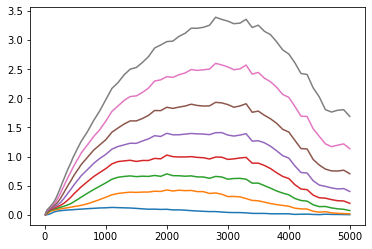

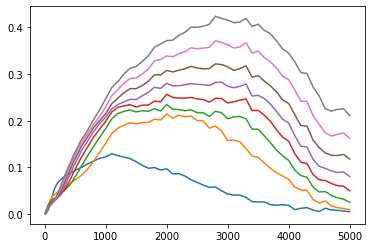

In [ ]:
# Representación todos juntos O 8 gráficas para cada serie de datos. En el caso de que las representemos todas juntas: 

for w in range(0,8):
  plt.plot(dt,MI[:,w])
plt.show()

for w in range(0,8):
  plt.plot(dt,MI[:,w]/(w+1))


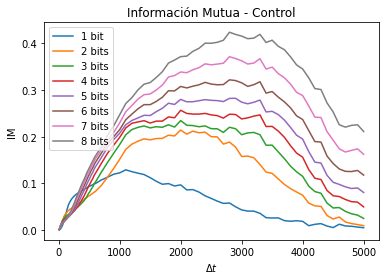

In [ ]:
for w in range(0,8):
  a = w+1
  if a==1:
    plt.plot(dt,MI[:,w]/(w+1), label='%d bit' %a )
  else: 
    plt.plot(dt,MI[:,w]/(w+1), label='%d bits' %a )


plt.title('Información Mutua - Control')
plt.legend(loc="upper left")
plt.ylabel('IM')
plt.xlabel('$\Delta t$')
plt.savefig('IM-Control (5000)')
plt.show()


In [ ]:
for w in range(0,8):
  a = w+1
  if a==1:
    plt.plot(dt[:9],MI[:9,w]/(w+1))
    plt.title('Información Mutua - Control')
    plt.ylabel('IM (1 bit)')
    plt.xlabel('$\Delta t$')
    plt.savefig('IM-Control (200-1)')
    plt.show()
  else: 
    plt.plot(dt[:9],MI[:9,w]/(w+1))
    plt.title('Información Mutua - Control')
    plt.ylabel('IM (%d bits)' %a)
    plt.xlabel('$\Delta t$')
    plt.savefig('IM-Control (200-%d)' %a)
    plt.show()


In [ ]:
for w in range(0,8):
  a = w+1
  if a==1: # LA INFORMACIÓN TRANSMITIDA NO SE DIVIDE POR EL TAMAÑO DEL BIN
    plt.plot(dt[:9],E_C0_to_C1[:9,w], label='de LP a VD')
    plt.plot(dt[:9],E_C1_to_C0[:9,w], label='de VD a LP')
    plt.title('Información transmitida entre neuronas - Control')
    plt.legend(loc="upper left")
    plt.ylabel('IT (1 bit)')
    plt.xlabel('$\Delta t$')
    plt.savefig('InfT-Control (200-1)')
    plt.show()
  else: 
    plt.plot(dt[:9],E_C0_to_C1[:9,w], label='de LP a VD')
    plt.plot(dt[:9],E_C1_to_C0[:9,w], label='de VD a LP')
    plt.title('Información transmitida entre neuronas - Control')
    plt.legend(loc="upper left")
    plt.ylabel('IT (%d bits)' %a)
    plt.xlabel('$\Delta t$')
    plt.savefig('InfT-Control (200-%d)' %a)
    plt.show()

In [ ]:
df1 = []
it1 = []

for w in range(0,8):
  idx = 0
  for i in dt:
    aux1 = w+1

    df = np.array((i,aux1,'C',MI[idx,w])) #/(w+1) Sin normalizar 
    it = np.array((i,aux1,'C',E_C0_to_C1[idx,w],E_C1_to_C0[idx,w]))
    # print(df)
    # print(dfi)
    df1.append(df)
    it1.append(it)
    idx += 1


In [ ]:
df1 = np.array(df1)
df2 = pd.DataFrame(df1)
it1 = np.array(it1)
it2 = pd.DataFrame(it1)
df2.to_csv('bin_MI.csv', sep = ',', header = False, index = False)
it2.to_csv('bin_IT.csv', sep = ',', header = False, index = False)

## Representación series de datos 

In [ ]:
x = pd.read_csv('bin_MI (1).csv',header=None,skiprows=1)
y = pd.read_csv('bin_H.csv',header=None,skiprows=1)

In [ ]:
print(x.shape) # dt,w,serie,MI
print(y.shape) # dt,w,serie,neuron,H

(1088, 4)
(2176, 5)


In [ ]:
xC = pd.read_csv('bin_MI (2).csv',header=None)
yC = pd.read_csv('bin_IT.csv',header=None)
print(x.shape) # dt,w,serie,MI
print(y.shape) #dt,w,serie,Ec0-c1,Ec1-c0

(1088, 4)
(2176, 5)


### MI  

dt,w,serie,MI

In [ ]:
filterR = x[2]=='R'
xR = x.where(filterR)
xR = xR.dropna()

filterG = x[2]=='G'
xG = x.where(filterG)
xG = xG.dropna()


In [ ]:
print(xR.shape) 
print(xG.shape)
print(xR)

### Inf. transmitida

dt,w,serie,neuron,H

In [ ]:
filterR = y[2]=='R'
yR = y.where(filterR)
yR = yR.dropna()

filterR1 = yR[3]==1
yR1 = yR.where(filterR1)
yR1 = yR1.dropna()

filterR0 = yR[3]==0
yR0 = yR.where(filterR0)
yR0 = yR0.dropna()

filterG = y[2]=='G'
yG = y.where(filterG)
yG = yG.dropna()

filterG1 = yG[3]==1
yG1 = yG.where(filterG1)
yG1 = yG1.dropna()

filterG0 = yG[3]==0
yG0 = yG.where(filterG0)
yG0 = yG0.dropna()

In [ ]:
print(yR.shape) 
print(yG.shape)
print(yR1)

 ### datos R

In [ ]:
for w in range(0,8):
  a = w+1
  if a==1:
    filterR = xR[1]==a
    xRw = xR.where(filterR)
    xRw = xRw.dropna()
    
    plt.plot(xRw[0][:9],xRw[3][:9]/(w+1))
    plt.title('Información Mutua - Recuperación')
    plt.ylabel('IM (1 bit)')
    plt.xlabel('$\Delta t$')
    plt.savefig('IM-Recuperación (200-1)')
    plt.show()

    filterR1 = yR1[1]==a
    filterR0 = yR0[1]==a
    yRw1 = yR1.where(filterR1)
    yRw0 = yR0.where(filterR0)
    yRw1 = yRw1.dropna()
    yRw0 = yRw0.dropna()

    div1 = np.array(xRw[3][:9])/np.array(yRw1[4][:9])
    div0 = np.array(xRw[3][:9])/np.array(yRw0[4][:9])
  
    plt.plot(yRw1[0][:9],div1, label='de LP a VD')
    plt.plot(yRw0[0][:9],div0, label='de VD a LP')
    plt.title('Información transmitida entre neuronas - Recuperación')
    plt.legend(loc="upper left")
    plt.ylabel('IT (1 bit)')
    plt.xlabel('$\Delta t$')
    plt.savefig('InfT-Recuperación (200-1)')
    plt.show()
  else: 
    filterR = xR[1]==a
    xRw = xR.where(filterR)
    xRw = xRw.dropna()
    
    plt.plot(xRw[0][:9],xRw[3][:9]/(w+1))
    plt.title('Información Mutua - Recuperación')
    plt.ylabel('IM (%d bit)' %a)
    plt.xlabel('$\Delta t$')
    plt.savefig('IM-Recuperación (200-%d)' %a)
    plt.show()

    filterR1 = yR1[1]==a
    filterR0 = yR0[1]==a
    yRw1 = yR1.where(filterR1)
    yRw0 = yR0.where(filterR0)
    yRw1 = yRw1.dropna()
    yRw0 = yRw0.dropna()

    div1 = np.array(xRw[3][:9])/np.array(yRw1[4][:9])
    div0 = np.array(xRw[3][:9])/np.array(yRw0[4][:9])

    plt.plot(yRw1[0][:9],div1, label='de LP a VD')
    plt.plot(yRw0[0][:9],div0, label='de VD a LP')
    plt.title('Información transmitida entre neuronas - Recuperación')
    plt.legend(loc="upper left")
    plt.ylabel('IT (%d bits)' %a)
    plt.xlabel('$\Delta t$')
    plt.savefig('InfT-Recuperación (200-%d)' %a)
    plt.show()

### Datos G

In [ ]:
for w in range(0,8):
  a = w+1
  if a==1:
    filterG = xG[1]==a
    xGw = xG.where(filterG)
    xGw = xGw.dropna()
    
    plt.plot(xGw[0][:9],xGw[3][:9]/(w+1))
    plt.title('Información Mutua - Gaba')
    plt.ylabel('IM (1 bit)')
    plt.xlabel('$\Delta t$')
    plt.savefig('IM-Gaba (200-1)')
    plt.show()

    filterG1 = yG1[1]==a
    filterG0 = yG0[1]==a
    yGw1 = yG1.where(filterG1)
    yGw0 = yG0.where(filterG0)
    yGw1 = yGw1.dropna()
    yGw0 = yGw0.dropna()

    div1 = np.array(xGw[3][:9])/np.array(yGw1[4][:9])
    div0 = np.array(xGw[3][:9])/np.array(yGw0[4][:9])
  
    plt.plot(yGw1[0][:9],div1, label='de LP a VD')
    plt.plot(yGw0[0][:9],div0, label='de VD a LP')
    plt.title('Información transmitida entre neuronas - Gaba')
    plt.legend(loc="upper left")
    plt.ylabel('IT (1 bit)')
    plt.xlabel('$\Delta t$')
    plt.savefig('InfT-Gaba (200-1)')
    plt.show()
  else: 
    filterG = xG[1]==a
    xGw = xG.where(filterG)
    xGw = xGw.dropna()
    
    plt.plot(xGw[0][:9],xGw[3][:9]/(w+1))
    plt.title('Información Mutua - Gaba')
    plt.ylabel('IM (%d bit)' %a)
    plt.xlabel('$\Delta t$')
    plt.savefig('IM-Gaba (200-%d)' %a)
    plt.show()

    filterG1 = yG1[1]==a
    filterG0 = yG0[1]==a
    yGw1 = yG1.where(filterG1)
    yGw0 = yG0.where(filterG0)
    yGw1 = yGw1.dropna()
    yGw0 = yGw0.dropna()

    div1 = np.array(xGw[3][:9])/np.array(yGw1[4][:9])
    div0 = np.array(xGw[3][:9])/np.array(yGw0[4][:9])

    plt.plot(yGw1[0][:9],div1, label='de LP a VD')
    plt.plot(yGw0[0][:9],div0, label='de VD a LP')
    plt.title('Información transmitida entre neuronas - Gaba')
    plt.legend(loc="upper left")
    plt.ylabel('IT (%d bits)' %a)
    plt.xlabel('$\Delta t$')
    plt.savefig('InfT-Gaba (200-%d)' %a)
    plt.show()

### Las 3 series de datos juntos


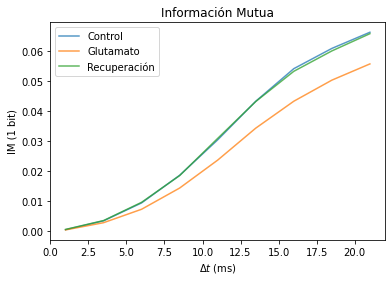

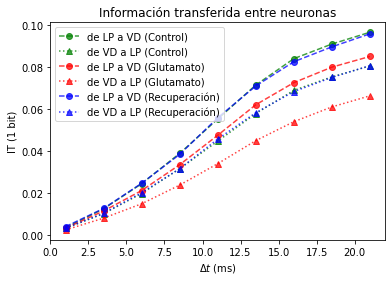

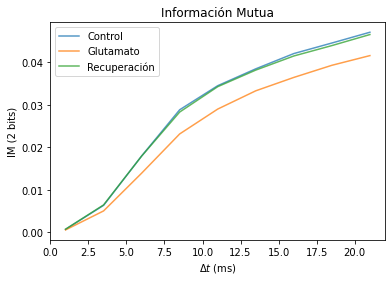

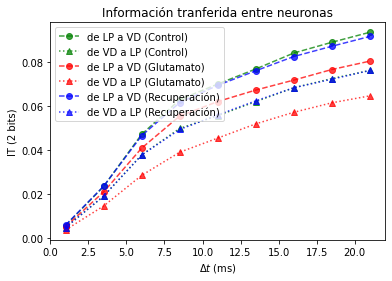

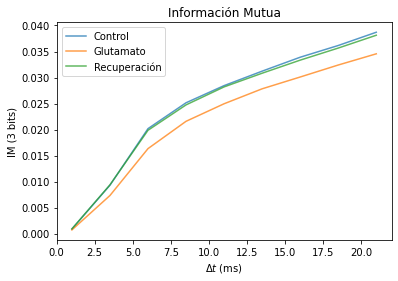

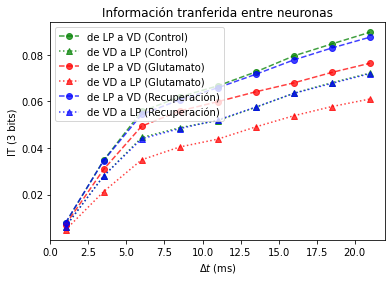

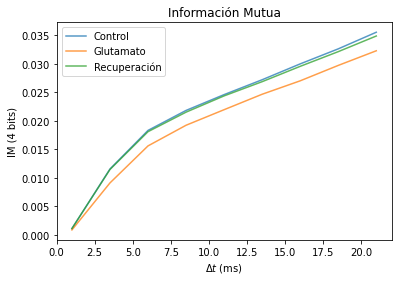

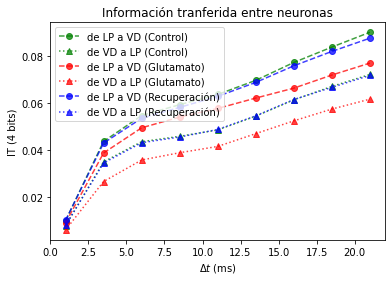

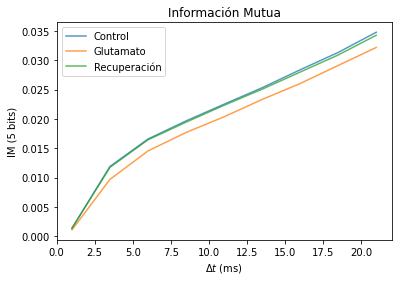

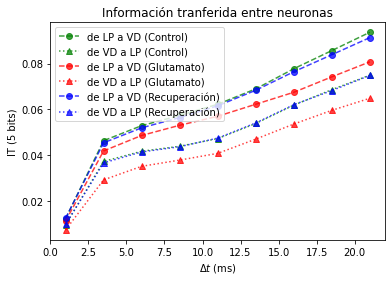

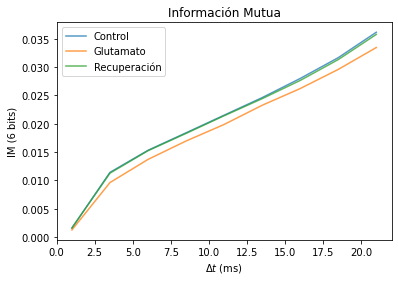

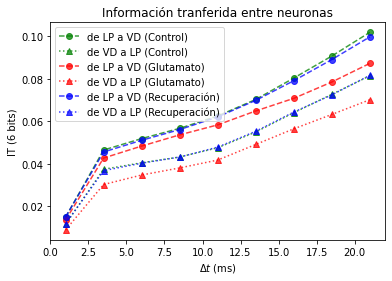

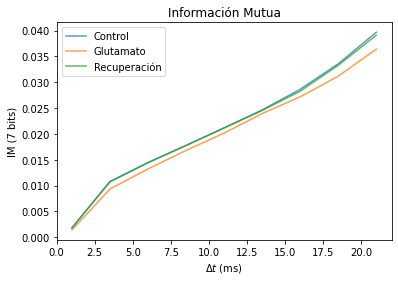

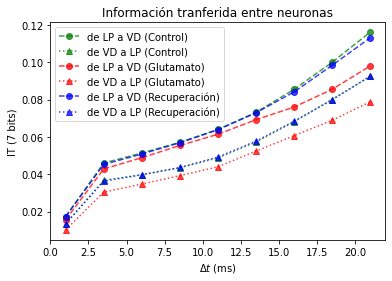

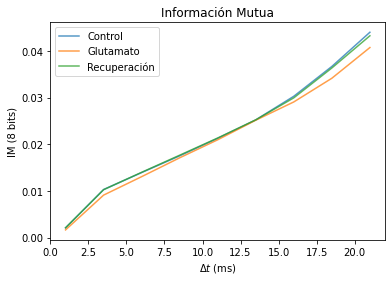

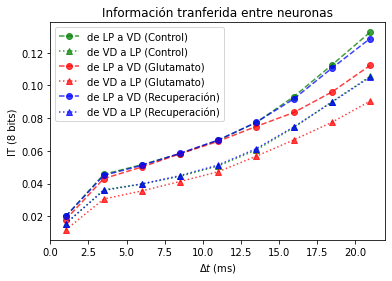

In [ ]:
for w in range(0,8):
  a = w+1
  if a==1:
    filterR = xR[1]==a
    xRw = xR.where(filterR)
    xRw = xRw.dropna()

    filterG = xG[1]==a
    xGw = xG.where(filterG)
    xGw = xGw.dropna()

    filterC = xC[1]==a
    xCw = xC.where(filterC)
    xCw = xCw.dropna()
    
    plt.plot(xCw[0][:9]/10,xCw[3][:9]/(w+1), label='Control', alpha=0.75)
    plt.plot(xGw[0][:9]/10,xGw[3][:9]/(w+1), label='Glutamato', alpha=0.75)
    plt.plot(xRw[0][:9]/10,xRw[3][:9]/(w+1), label='Recuperación', alpha=0.75)
    plt.title('Información Mutua')
    plt.legend(loc="upper left")
    plt.ylabel('IM (1 bit)')
    plt.xlabel('$\Delta t$ (ms)')
    plt.savefig('IM (dt210-bin1)')
    plt.show()

    filterR1 = yR1[1]==a
    filterR0 = yR0[1]==a
    yRw1 = yR1.where(filterR1)
    yRw0 = yR0.where(filterR0)
    yRw1 = yRw1.dropna()
    yRw0 = yRw0.dropna()

    divR1 = np.array(xRw[3][:9])/np.array(yRw1[4][:9])
    divR0 = np.array(xRw[3][:9])/np.array(yRw0[4][:9])

    filterG1 = yG1[1]==a
    filterG0 = yG0[1]==a
    yGw1 = yG1.where(filterG1)
    yGw0 = yG0.where(filterG0)
    yGw1 = yGw1.dropna()
    yGw0 = yGw0.dropna()

    divG1 = np.array(xGw[3][:9])/np.array(yGw1[4][:9])
    divG0 = np.array(xGw[3][:9])/np.array(yGw0[4][:9])

    filterC = yC[1]==a
    yCw = yC.where(filterC)
    yCw = yCw.dropna()
  
    plt.plot(yCw[0][:9]/10,yCw[3][:9], label='de LP a VD (Control)',color='green', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(yCw[0][:9]/10,yCw[4][:9], label='de VD a LP (Control)',color='green', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(yGw1[0][:9]/10,divG1, label='de LP a VD (Glutamato)',color='red', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(yGw0[0][:9]/10,divG0, label='de VD a LP (Glutamato)',color='red', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(yRw1[0][:9]/10,divR1, label='de LP a VD (Recuperación)',color='blue', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(yRw0[0][:9]/10,divR0, label='de VD a LP (Recuperación)',color='blue', alpha=0.75,linestyle =':',marker = '^')
    plt.title('Información transferida entre neuronas')
    plt.legend(loc="upper left")
    plt.ylabel('IT (1 bit)')
    plt.xlabel('$\Delta t$ (ms)')
    plt.savefig('InfT (dt210-bin1)')
    plt.show()
  else: 
    filterR = xR[1]==a
    xRw = xR.where(filterR)
    xRw = xRw.dropna()

    filterG = xG[1]==a
    xGw = xG.where(filterG)
    xGw = xGw.dropna()

    filterC = xC[1]==a
    xCw = xC.where(filterC)
    xCw = xCw.dropna()
    
    plt.plot(xCw[0][:9]/10,xCw[3][:9]/(w+1), label='Control', alpha=0.75)
    plt.plot(xGw[0][:9]/10,xGw[3][:9]/(w+1), label='Glutamato', alpha=0.75)
    plt.plot(xRw[0][:9]/10,xRw[3][:9]/(w+1), label='Recuperación', alpha=0.75)
    plt.title('Información Mutua')
    plt.legend(loc="upper left")
    plt.ylabel('IM (%d bits)' %a)
    plt.xlabel('$\Delta t$ (ms)')
    plt.savefig('IM (dt210-bin%d)' %a)
    plt.show()

    filterR1 = yR1[1]==a
    filterR0 = yR0[1]==a
    yRw1 = yR1.where(filterR1)
    yRw0 = yR0.where(filterR0)
    yRw1 = yRw1.dropna()
    yRw0 = yRw0.dropna()

    divR1 = np.array(xRw[3][:9])/np.array(yRw1[4][:9])
    divR0 = np.array(xRw[3][:9])/np.array(yRw0[4][:9])

    filterG1 = yG1[1]==a
    filterG0 = yG0[1]==a
    yGw1 = yG1.where(filterG1)
    yGw0 = yG0.where(filterG0)
    yGw1 = yGw1.dropna()
    yGw0 = yGw0.dropna()

    divG1 = np.array(xGw[3][:9])/np.array(yGw1[4][:9])
    divG0 = np.array(xGw[3][:9])/np.array(yGw0[4][:9])

    filterC = yC[1]==a
    yCw = yC.where(filterC)
    yCw = yCw.dropna()

    plt.plot(yCw[0][:9]/10,yCw[3][:9], label='de LP a VD (Control)',color='green', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(yCw[0][:9]/10,yCw[4][:9], label='de VD a LP (Control)',color='green', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(yGw1[0][:9]/10,divG1, label='de LP a VD (Glutamato)',color='red', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(yGw0[0][:9]/10,divG0, label='de VD a LP (Glutamato)',color='red', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(yRw1[0][:9]/10,divR1, label='de LP a VD (Recuperación)',color='blue', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(yRw0[0][:9]/10,divR0, label='de VD a LP (Recuperación)',color='blue', alpha=0.75,linestyle =':',marker = '^')
    plt.title('Información tranferida entre neuronas')
    plt.legend(loc="upper left")
    plt.ylabel('IT (%d bits)' %a)
    plt.xlabel('$\Delta t$ (ms)')
    plt.savefig('InfT (dt210-bin%d)' %a)
    plt.show()

### SAX

In [ ]:
xS = pd.read_csv('sax_MI (1).csv',header=None,skiprows=1)
yS = pd.read_csv('sax_H.csv',header=None,skiprows=1)

In [ ]:
filterR = xS[3]=='R'
xSR = xS.where(filterR)
xSR = xSR.dropna()

filterG = xS[3]=='G'
xSG = xS.where(filterG)
xSG = xSG.dropna()

filterC = xS[3]=='C'
xSC = xS.where(filterC)
xSC = xSC.dropna()


In [ ]:
filterR = yS[3]=='R'
ySR = yS.where(filterR)
ySR = ySR.dropna()

filterR1 = ySR[4]==1
ySR1 = ySR.where(filterR1)
ySR1 = ySR1.dropna()

filterR0 = ySR[4]==0
ySR0 = ySR.where(filterR0)
ySR0 = ySR0.dropna()

filterG = yS[3]=='G'
ySG = yS.where(filterG)
ySG = ySG.dropna()

filterG1 = ySG[4]==1
ySG1 = ySG.where(filterG1)
ySG1 = ySG1.dropna()

filterG0 = ySG[4]==0
ySG0 = ySG.where(filterG0)
ySG0 = ySG0.dropna()

filterC = yS[3]=='C'
ySC = yS.where(filterC)
ySC = ySC.dropna()

filterC1 = ySC[4]==1
ySC1 = ySC.where(filterC1)
ySC1 = ySC1.dropna()

filterC0 = ySC[4]==0
ySC0 = ySC.where(filterC0)
ySC0 = ySC0.dropna()

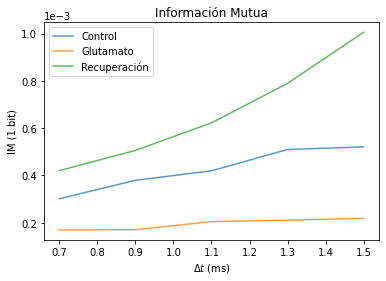

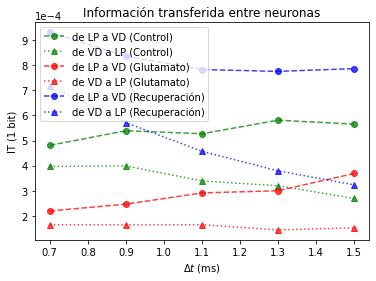

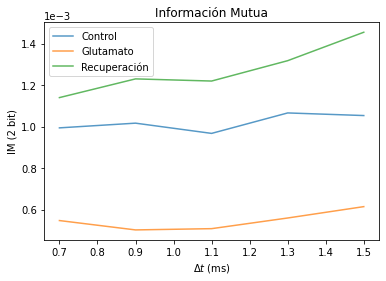

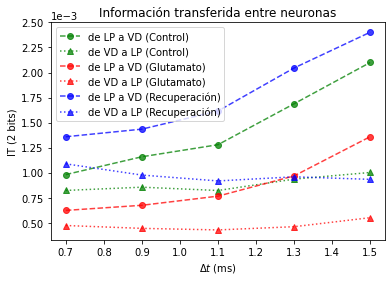

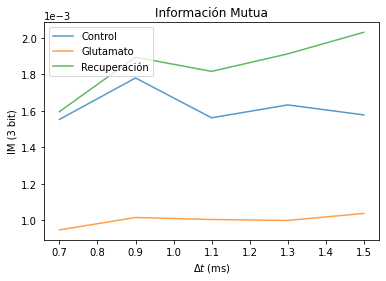

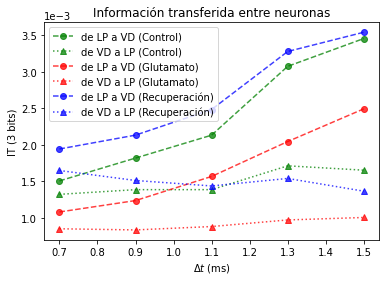

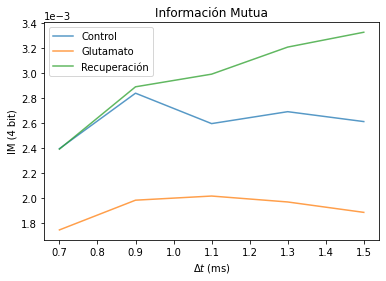

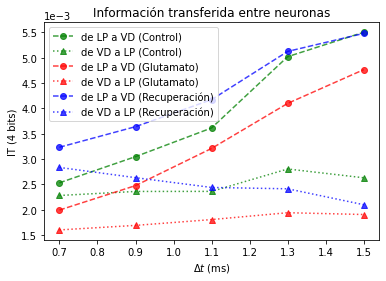

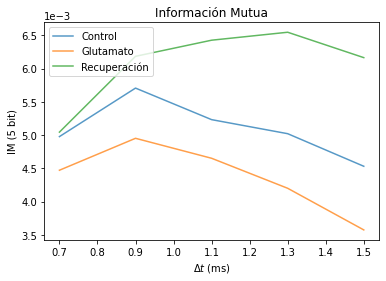

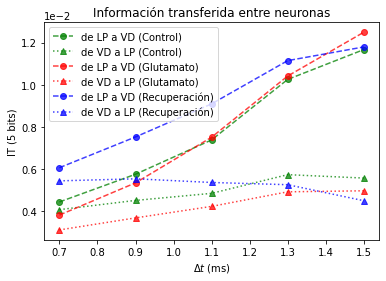

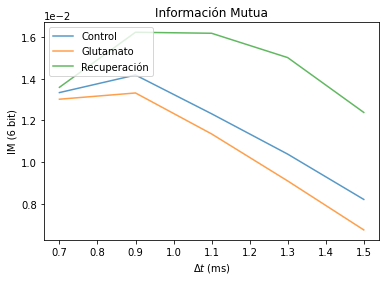

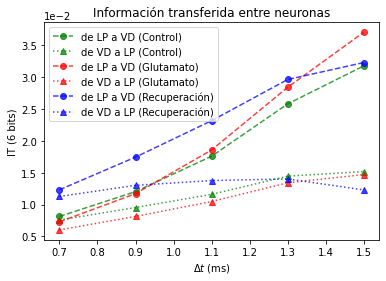

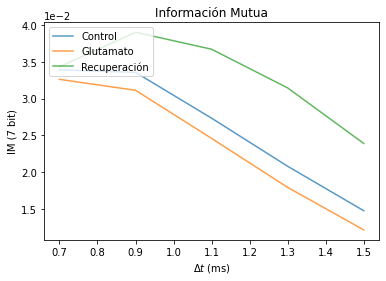

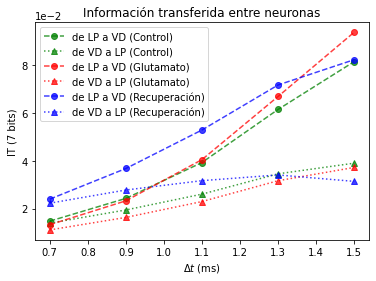

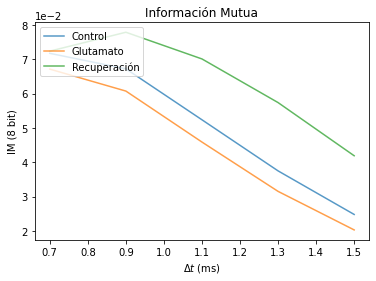

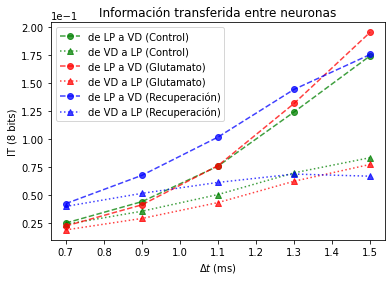

In [ ]:
from matplotlib.ticker import FormatStrFormatter

for w in range(0,8):
  a = w+1
  if a==1:
    filterR = xSR[2]==a
    xSRw = xSR.where(filterR)
    xSRw = xSRw.dropna()

    filterG = xSG[2]==a
    xSGw = xSG.where(filterG)
    xSGw = xSGw.dropna()

    filterC = xSC[2]==a
    xSCw = xSC.where(filterC)
    xSCw = xSCw.dropna()
    
    plt.plot(xSCw[0]/10,xSCw[4]/(w+1), label='Control', alpha=0.75)
    plt.plot(xSGw[0]/10,xSGw[4]/(w+1), label='Glutamato', alpha=0.75)
    plt.plot(xSRw[0]/10,xSRw[4]/(w+1), label='Recuperación', alpha=0.75)
    plt.title('Información Mutua')
    plt.legend(loc="upper left")
    plt.ylabel('IM (1 bit)')
    plt.xlabel('$\Delta t$ (ms)')
    plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
    plt.savefig('IM_SAX (dt210-bin1)')
    plt.show()

    filterR1 = ySR1[2]==a
    filterR0 = ySR0[2]==a
    ySRw1 = ySR1.where(filterR1)
    ySRw0 = ySR0.where(filterR0)
    ySRw1 = ySRw1.dropna()
    ySRw0 = ySRw0.dropna()

    divR1 = np.array(xSRw[4])/np.array(ySRw1[5])
    divR0 = np.array(xSRw[4])/np.array(ySRw0[5])

    filterG1 = ySG1[2]==a
    filterG0 = ySG0[2]==a
    ySGw1 = ySG1.where(filterG1)
    ySGw0 = ySG0.where(filterG0)
    ySGw1 = ySGw1.dropna()
    ySGw0 = ySGw0.dropna()

    divG1 = np.array(xSGw[4])/np.array(ySGw1[5])
    divG0 = np.array(xSGw[4])/np.array(ySGw0[5])

    filterC1 = ySC1[2]==a
    filterC0 = ySC0[2]==a
    ySCw1 = ySC1.where(filterC1)
    ySCw0 = ySC0.where(filterC0)
    ySCw1 = ySCw1.dropna()
    ySCw0 = ySCw0.dropna()

    divC1 = np.array(xSCw[4])/np.array(ySCw1[5])
    divC0 = np.array(xSCw[4])/np.array(ySCw0[5])
  
    plt.plot(ySCw1[0]/10,divC1, label='de LP a VD (Control)',color='green', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(ySCw0[0]/10,divC0, label='de VD a LP (Control)',color='green', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(ySGw1[0]/10,divG1, label='de LP a VD (Glutamato)',color='red', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(ySGw0[0]/10,divG0, label='de VD a LP (Glutamato)',color='red', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(ySRw1[0]/10,divR1, label='de LP a VD (Recuperación)',color='blue', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(ySRw0[0]/10,divR0, label='de VD a LP (Recuperación)',color='blue', alpha=0.75,linestyle =':',marker = '^')
    plt.title('Información transferida entre neuronas')
    plt.legend(loc="upper left")
    plt.ylabel('IT (1 bit)')
    plt.xlabel('$\Delta t$ (ms)')
    plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
    plt.savefig('InfT_SAX (dt210-bin1)')
    plt.show()
  else: 
    filterR = xSR[2]==a
    xSRw = xSR.where(filterR)
    xSRw = xSRw.dropna()

    filterG = xSG[2]==a
    xSGw = xSG.where(filterG)
    xSGw = xSGw.dropna()

    filterC = xSC[2]==a
    xSCw = xSC.where(filterC)
    xSCw = xSCw.dropna()
    
    plt.plot(xSCw[0]/10,xSCw[4]/(w+1), label='Control', alpha=0.75)
    plt.plot(xSGw[0]/10,xSGw[4]/(w+1), label='Glutamato', alpha=0.75)
    plt.plot(xSRw[0]/10,xSRw[4]/(w+1), label='Recuperación', alpha=0.75)
    plt.title('Información Mutua')
    plt.legend(loc="upper left")
    plt.ylabel('IM (%d bit)' %a)
    plt.xlabel('$\Delta t$ (ms)')
    plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
    plt.savefig('IM_SAX (dt210-bin%d)' %a)
    plt.show()

    filterR1 = ySR1[2]==a
    filterR0 = ySR0[2]==a
    ySRw1 = ySR1.where(filterR1)
    ySRw0 = ySR0.where(filterR0)
    ySRw1 = ySRw1.dropna()
    ySRw0 = ySRw0.dropna()

    divR1 = np.array(xSRw[4])/np.array(ySRw1[5])
    divR0 = np.array(xSRw[4])/np.array(ySRw0[5])

    filterG1 = ySG1[2]==a
    filterG0 = ySG0[2]==a
    ySGw1 = ySG1.where(filterG1)
    ySGw0 = ySG0.where(filterG0)
    ySGw1 = ySGw1.dropna()
    ySGw0 = ySGw0.dropna()

    divG1 = np.array(xSGw[4])/np.array(ySGw1[5])
    divG0 = np.array(xSGw[4])/np.array(ySGw0[5])

    filterC1 = ySC1[2]==a
    filterC0 = ySC0[2]==a
    ySCw1 = ySC1.where(filterC1)
    ySCw0 = ySC0.where(filterC0)
    ySCw1 = ySCw1.dropna()
    ySCw0 = ySCw0.dropna()

    divC1 = np.array(xSCw[4])/np.array(ySCw1[5])
    divC0 = np.array(xSCw[4])/np.array(ySCw0[5])

    plt.plot(ySCw1[0]/10,divC1, label='de LP a VD (Control)',color='green', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(ySCw0[0]/10,divC0, label='de VD a LP (Control)',color='green', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(ySGw1[0]/10,divG1, label='de LP a VD (Glutamato)',color='red', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(ySGw0[0]/10,divG0, label='de VD a LP (Glutamato)',color='red', alpha=0.75,linestyle =':',marker = '^')
    plt.plot(ySRw1[0]/10,divR1, label='de LP a VD (Recuperación)',color='blue', alpha=0.75,linestyle ='--',marker = 'o')
    plt.plot(ySRw0[0]/10,divR0, label='de VD a LP (Recuperación)',color='blue', alpha=0.75,linestyle =':',marker = '^')
    plt.title('Información transferida entre neuronas')
    plt.legend(loc="upper left")
    plt.ylabel('IT (%d bits)' %a)
    plt.xlabel('$\Delta t$ (ms)')
    plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
    plt.savefig('InfT_SAX (dt210-bin%d)' %a)
    plt.show()

### OP

In [ ]:
xO = pd.read_csv('op_MI.csv',header=None,skiprows=1)
yO = pd.read_csv('op_H.csv',header=None,skiprows=1)

xO = xO.sort_values(by=[0])
yO = yO.sort_values(by=[0])


In [ ]:
filterR = xO[2]=='R'
xOR = xO.where(filterR)
xOR = xOR.dropna()

filterG = xO[2]=='G'
xOG = xO.where(filterG)
xOG = xOG.dropna()

filterC = xO[2]=='C'
xOC = xO.where(filterC)
xOC = xOC.dropna()

In [ ]:
filterR = yO[2]=='R'
yOR = yO.where(filterR)
yOR = yOR.dropna()

filterR1 = yOR[3]==1
yOR1 = yOR.where(filterR1)
yOR1 = yOR1.dropna()

filterR0 = yOR[3]==0
yOR0 = yOR.where(filterR0)
yOR0 = yOR0.dropna()

filterG = yO[2]=='G'
yOG = yO.where(filterG)
yOG = yOG.dropna()

filterG1 = yOG[3]==1
yOG1 = yOG.where(filterG1)
yOG1 = yOG1.dropna()

filterG0 = yOG[3]==0
yOG0 = yOG.where(filterG0)
yOG0 = yOG0.dropna()

filterC = yO[2]=='C'
yOC = yO.where(filterC)
yOC = yOC.dropna()

filterC1 = yOC[3]==1
yOC1 = yOC.where(filterC1)
yOC1 = yOC1.dropna()

filterC0 = yOC[3]==0
yOC0 = yOC.where(filterC0)
yOC0 = yOC0.dropna()

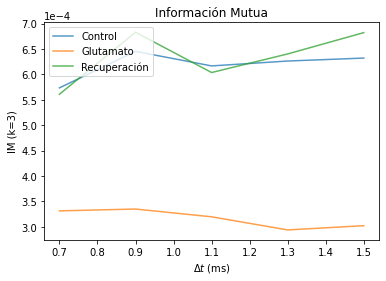

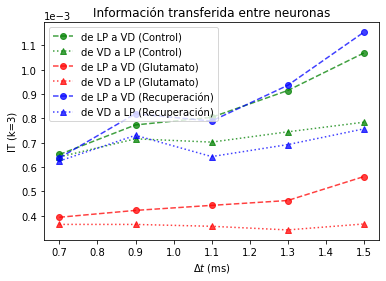

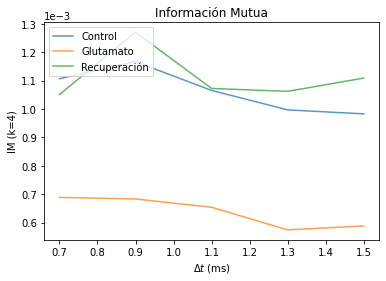

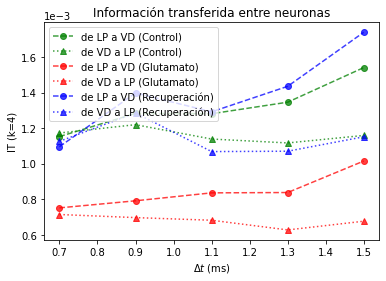

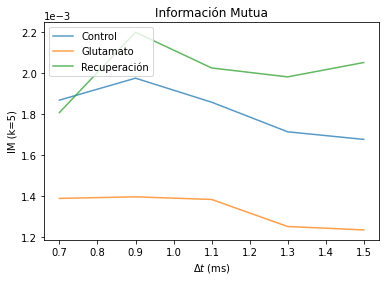

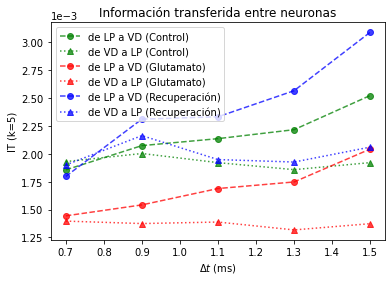

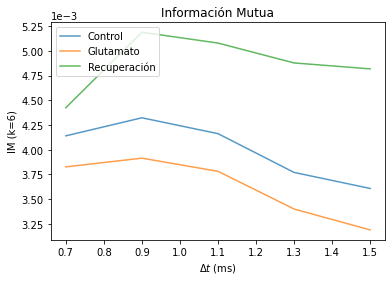

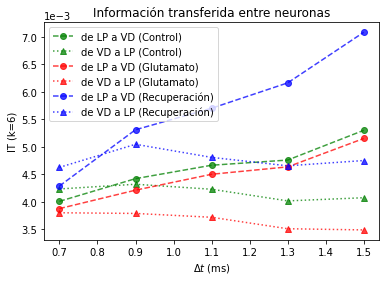

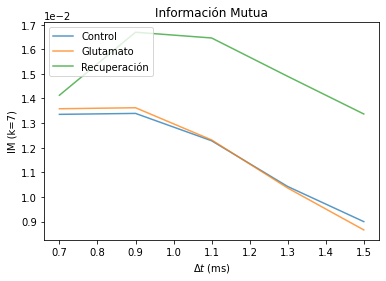

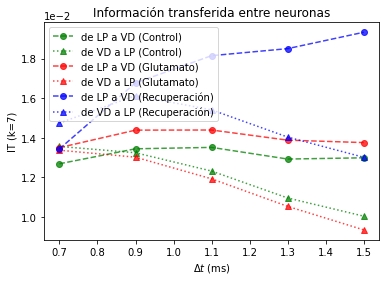

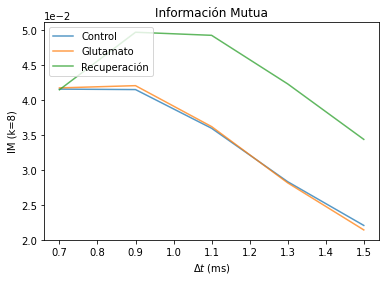

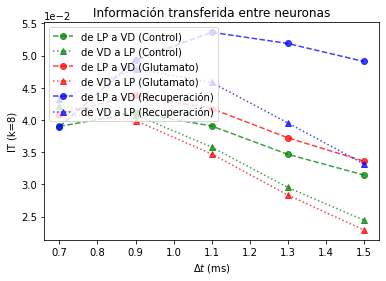

In [ ]:
for w in range(3,9):
  
  filterR = xOR[1]==w
  xORw = xOR.where(filterR)
  xORw = xORw.dropna()

  filterG = xOG[1]==w
  xOGw = xOG.where(filterG)
  xOGw = xOGw.dropna()

  filterC = xOC[1]==w
  xOCw = xOC.where(filterC)
  xOCw = xOCw.dropna()
  
  plt.plot(xOCw[0]/10,xOCw[3]/w, label='Control', alpha=0.75)
  plt.plot(xOGw[0]/10,xOGw[3]/w, label='Glutamato', alpha=0.75)
  plt.plot(xORw[0]/10,xORw[3]/w, label='Recuperación', alpha=0.75)
  plt.title('Información Mutua')
  plt.legend(loc="upper left")
  plt.ylabel('IM (k=%d)' %w)
  plt.xlabel('$\Delta t$ (ms)')
  plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
  plt.savefig('IM_OP (dt210-k%d)' %w)
  plt.show()

  filterR1 = yOR1[1]==w
  filterR0 = yOR0[1]==w
  yORw1 = yOR1.where(filterR1)
  yORw0 = yOR0.where(filterR0)
  yORw1 = yORw1.dropna()
  yORw0 = yORw0.dropna()

  divR1 = np.array(xORw[3])/np.array(yORw1[4])
  divR0 = np.array(xORw[3])/np.array(yORw0[4])

  filterG1 = yOG1[1]==w
  filterG0 = yOG0[1]==w
  yOGw1 = yOG1.where(filterG1)
  yOGw0 = yOG0.where(filterG0)
  yOGw1 = yOGw1.dropna()
  yOGw0 = yOGw0.dropna()

  divG1 = np.array(xOGw[3])/np.array(yOGw1[4])
  divG0 = np.array(xOGw[3])/np.array(yOGw0[4])

  filterC1 = yOC1[1]==w
  filterC0 = yOC0[1]==w
  yOCw1 = yOC1.where(filterC1)
  yOCw0 = yOC0.where(filterC0)
  yOCw1 = yOCw1.dropna()
  yOCw0 = yOCw0.dropna()

  divC1 = np.array(xOCw[3])/np.array(yOCw1[4])
  divC0 = np.array(xOCw[3])/np.array(yOCw0[4])

  plt.plot(yOCw1[0]/10,divC1, label='de LP a VD (Control)',color='green', alpha=0.75,linestyle ='--',marker = 'o')
  plt.plot(yOCw0[0]/10,divC0, label='de VD a LP (Control)',color='green', alpha=0.75,linestyle =':',marker = '^')
  plt.plot(yOGw1[0]/10,divG1, label='de LP a VD (Glutamato)',color='red', alpha=0.75,linestyle ='--',marker = 'o')
  plt.plot(yOGw0[0]/10,divG0, label='de VD a LP (Glutamato)',color='red', alpha=0.75,linestyle =':',marker = '^')
  plt.plot(yORw1[0]/10,divR1, label='de LP a VD (Recuperación)',color='blue', alpha=0.75,linestyle ='--',marker = 'o')
  plt.plot(yORw0[0]/10,divR0, label='de VD a LP (Recuperación)',color='blue', alpha=0.75,linestyle =':',marker = '^')
  plt.title('Información transferida entre neuronas')
  plt.legend(loc="upper left")
  plt.ylabel('IT (k=%d)' %w)
  plt.xlabel('$\Delta t$ (ms)')
  plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
  plt.savefig('InfT_OP (dt210-k%d)' %w)
  plt.show()